In [17]:
# import all modules
import numpy as np
import PIL.Image as Image
import libtiff
from matplotlib import pyplot as plt
import matplotlib
from skimage import io
from PRIS import SingleObs
import copy
import drawnow

# Construct obseration operator

In [2]:
# construct observation operator.
 # load psf matrix
dpath = './test_data/psf.tif';
psf = io.imread(dpath)


# Load observation

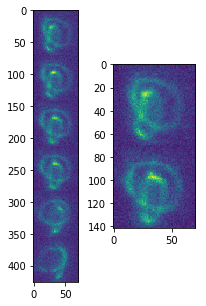

In [3]:
# load observation
data_path = './test_data';
f = 'obsStack.tif';
fov = io.imread(data_path + '/' + f)
fov.shape
plt.figure(figsize=(5,5));
plt.subplot(131)
plt.imshow(fov[[1,3,5,6,10,15],:,:].reshape(6*fov.shape[1],fov.shape[2]))
blur1 = fov[1,:,:];
blur2 = fov[5,:,:];

blur = np.concatenate([blur1, blur2]).reshape(2*71,71);
plt.subplot(132)
plt.imshow(blur)

# Decide candidates

In [4]:
# decide candidates 
range_ind0 = np.arange(-30,25)
range_ind1 = np.arange(12,62,2)
range_ind2 = np.arange(10,60,2)
candidate_locs = list()
for i0 in range_ind0:
    for i1 in range_ind1:
        for i2 in range_ind2:
            candidate_locs.append([i0,i1,i2])

# Construct sensing matrix

In [5]:
# construct sensing matrix
    # dependencies: candidates, observation operator.
    # yield: sensing matrix
    # method: loop over all candidates and record the corresponding observations.
a = SingleObs()
a.psf = np.copy(psf)
a.psfz0 = 106
a.debug = False
a.imsize = blur1.shape
a.edge_padding = True
A = np.ndarray([blur.shape[0]*blur.shape[1], len(candidate_locs)+1])
A.shape
for count, loc in enumerate(candidate_locs):
#for count, loc in enumerate([[0,10,10],[10,10,10]]):
    
    loc1 = np.copy(loc); loc1[0] = np.copy(loc[0])-8
    loc2 = np.copy(loc); loc2[0] = np.copy(loc[0])+8
    a.location = loc1
    a.single_obs()
    a1 = a.obs.ravel()
    
    a.location = loc2
    a.single_obs()
    a2 = a.obs.ravel()
    
    A[:,count] = np.concatenate([a1.ravel(),a2.ravel()]).ravel()
A[:,len(candidate_locs)] = 1

# Define LinBreg

In [317]:
class LinBreg:
    import time
    def __init__(self, A, x, b):
        # solve for x from Ax = b.
        self.A = A # sensing matrix.
        self.x = x # coefficient vector for the pool of candidates.
        self.b = b # observation vector.
        self.mu = np.mean(self.b.ravel())  # shrinkage threshold.
        self.er = np.zeros(self.b.shape)
        self.erpj = np.zeros(self.x.shape)
        self.cumerr = np.zeros(self.x.shape)
        self.flag_stop = False # flag to stop optimization iteration.
        self.opts = False # debug flag.
        self.opts = False # debug flag.
        self.maxit = 2 # maximum iteration steps.
        self.debug_it_int = 1
        self.stepsize = 10 # step size.
        self.flag_positivity = True
        self.debug = False
        self.it_check_rem = 1
        self.iterations = list()
        self.hist_res = list()
        self.bg = list()
        self.alpha = 1
        
    def getready(self):
        if self.debug is True:
            import os
            # define the name of the directory to be created.
            path = "./debug_output"
            try:  
                os.mkdir(path)
            except OSError:  
                print ("Creation of the directory %s failed" % path)
            else:  
                print ("Successfully created the directory %s " % path)
                    
    def shrink(self,sk):
        sk[np.where(sk > self.mu)] -= self.mu
        sk[np.where(sk < -self.mu)] += self.mu
        sk[np.where((sk > -self.mu) * (sk < self.mu))] = 0
        return sk
    
    def go(self):
        t1 = time.time()
        it_count = 0
    
        # main linearized bregman iteration without kicking.
        while self.flag_stop is False:
            # incrementation of the iteration number.
            it_count += 1
            
            # calculate distance (error)
            self.er = self.b - np.dot(self.A, self.x) 
            self.debug_output(it_count, appstr='_a_er_update')
            
            # back projection of the error ('adding the errors back').
            self.erpj = np.dot(self.er, self.A)  
            self.debug_output(it_count, appstr='_b_erpj_update')
            
            # acumulation of the back projected error.
            self.cumerr += self.erpj*self.stepsize
            self.debug_output(it_count, appstr='_c_cumerr_update')
            
            # shrinkage to update the candidate coefficients.
            
            self.x = copy.deepcopy(self.cumerr)
            self.debug_output(it_count, appstr='_d_x_copy')
            
            self.x = self.alpha*self.shrink(self.x)   
            
            self.debug_output(it_count, appstr='_e_x_update')
            
            # positivity constraint:
            if self.flag_positivity is True: self.x[np.where(self.x < 0)] = 0
            self.debug_output(it_count, appstr='_f_positivity_update')
            
            # decide on the termination of iterations.
            if it_count > self.maxit: self.flag_stop = True
            
            # update the quantities for status tracking purposes.
            self.track_status(it_count, self.er)
            
            # check intermediate outputs. (Valid under debug mode).
            self.debug_output(it_count, appstr='_g_after_track_status')

    # Generate intermediate output under debug mode.
    def debug_output(self, it_count, appstr):
        if self.debug is True:
            if np.remainder(it_count, self.debug_it_int) == self.it_check_rem:
                print('intermediate output it#'+ str(it_count))
                temp = np.mean(self.x[0:self.x.size-1].reshape(range_ind0.size,range_ind1.size,range_ind2.size),axis=0)
                nrow = 3
                ncol = 3
                plt.figure(figsize=(7,7))
                plt.subplot(nrow, ncol, 1)
                plt.imshow(temp)
                t = plt.title('XY-plane projection')
                t.set_position([.5, 1.15])

                plt.subplot(nrow, ncol, 2)
                plt.plot(self.iterations, np.log(self.hist_res), '.')
                t = plt.title('Log(L2(res))')
                t.set_position([.5, 1.15])

                plt.subplot(nrow, ncol, 3)
                plt.plot(self.er.ravel(), '.')
                t = plt.title('err')
                t.set_position([.5, 1.15])

                plt.subplot(nrow, ncol, 4)
                plt.text(0,0.8,'mu: '+str(np.floor(self.mu)),fontsize=16)
                plt.text(0,0.6,'stepsize: '+str(np.floor(self.stepsize)),fontsize=16)
                
                plt.axis('off')

                plt.subplot(nrow, ncol, 5)
                plt.plot(self.iterations, self.bg, '.')
                t = plt.title('Background')
                t.set_position([.5, 1.15])

                plt.subplot(nrow, ncol, 6)
                plt.plot(self.x.ravel())
                t = plt.title('coefficients (x)')
                t.set_position([.5, 1.15])

                plt.subplot(nrow, ncol, 7)
                plt.plot(self.cumerr.ravel(), '.')
                t = plt.title('cumerr')
                t.set_position([.5, 1.15])

                plt.subplot(nrow, ncol, 8)
                plt.plot(self.cumerr.ravel(), '.')
                plt.plot([0,len(self.cumerr.ravel())],[self.mu,self.mu],'r')
                t = plt.title('cumerr and mu')
                t.set_position([.5, 1.15])

                plt.subplot(nrow, ncol, 9)
                plt.plot(self.erpj.ravel(), '.')
                t = plt.title('erorr back projection (erpj)')
                t.set_position([.5, 1.15])

                plt.tight_layout(rect=[0, 0.04, 1, 0.9])
                plt.subplots_adjust(top=0.85, left = 0.1)
                plt.savefig('./debug_output/plots_it' + str(it_count) + appstr +'.png', dpi=300, figsize=(100,80))
        
    def track_status(self, it_count, er):
        self.hist_res.append(np.linalg.norm(er))
        self.iterations.append(it_count)
        self.bg.append(self.x[self.x.size-1])

# Recovery

Creation of the directory ./debug_output failed
intermediate output it#1
intermediate output it#1
intermediate output it#1
intermediate output it#1
intermediate output it#1
intermediate output it#1
intermediate output it#1
intermediate output it#2
intermediate output it#2
intermediate output it#2
intermediate output it#2
intermediate output it#2
intermediate output it#2
intermediate output it#2
intermediate output it#3
intermediate output it#3
intermediate output it#3
intermediate output it#3
intermediate output it#3
intermediate output it#3
intermediate output it#3


C:\Users\xiyu\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


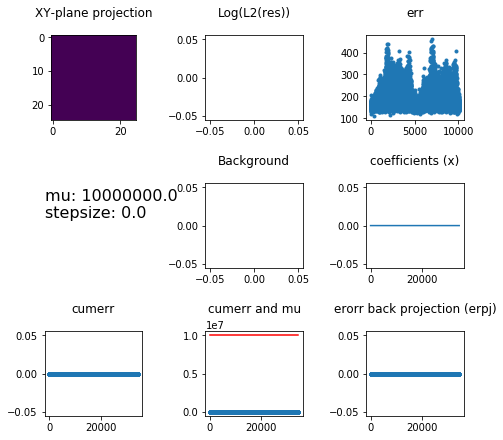

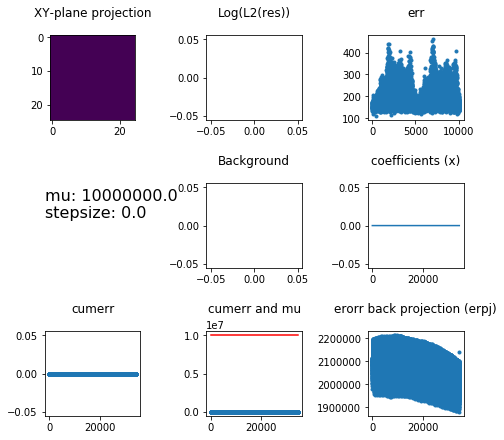

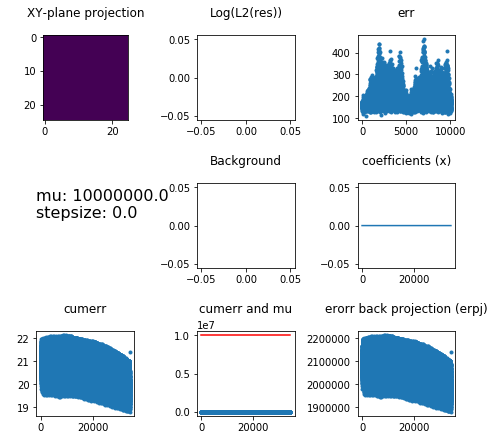

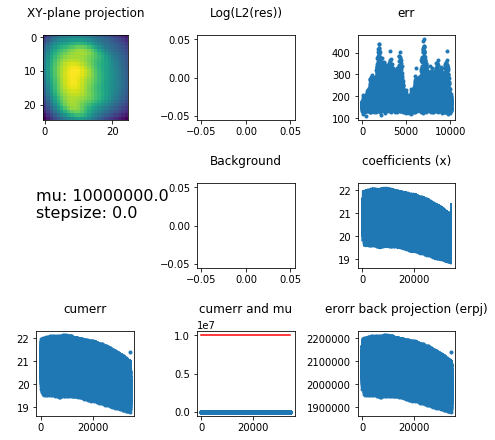

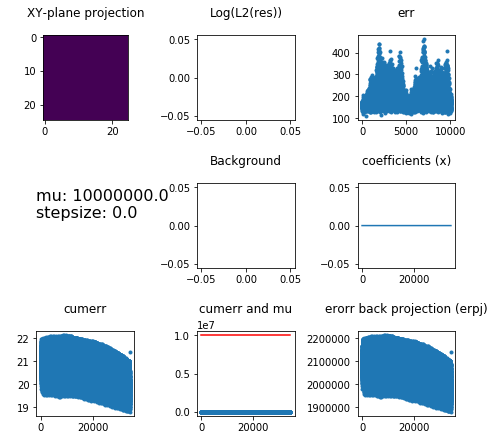

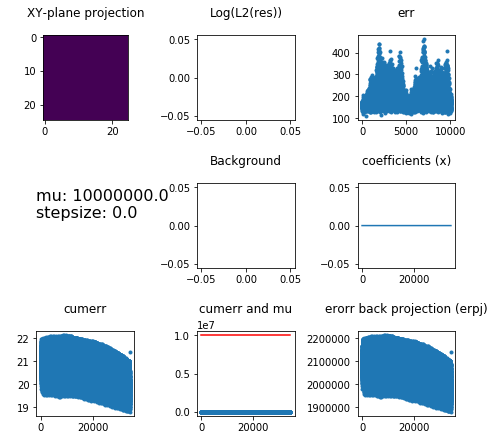

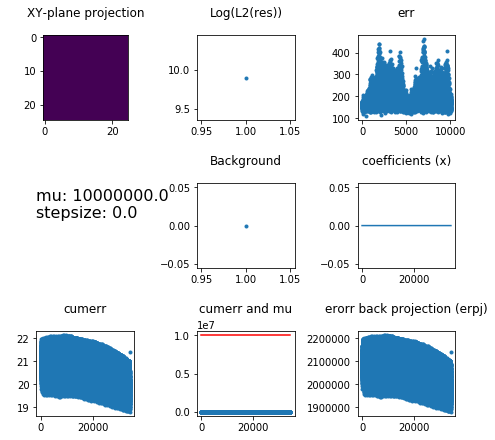

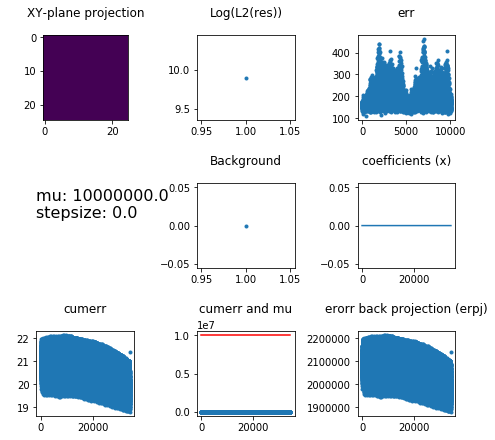

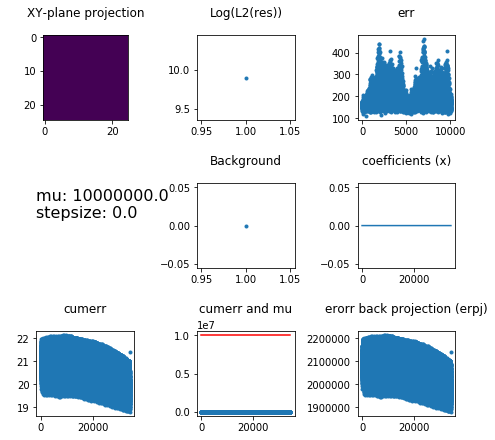

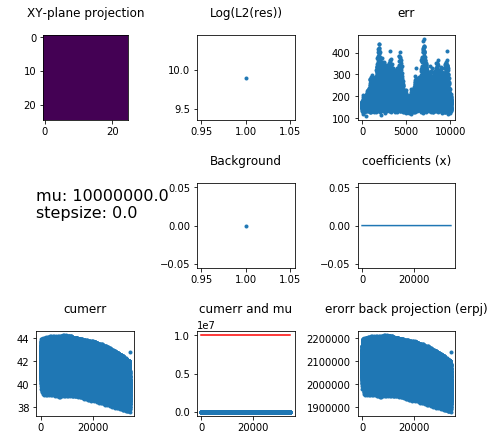

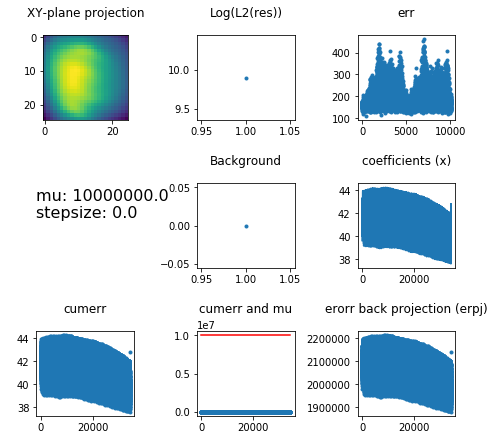

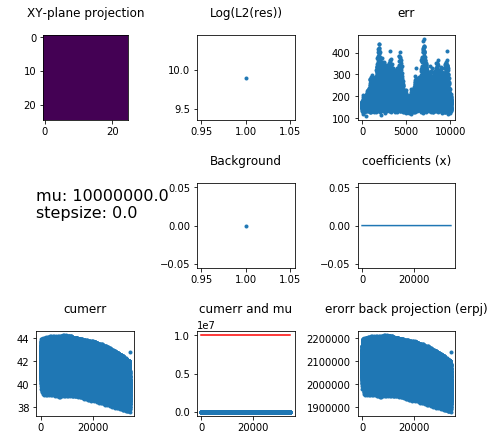

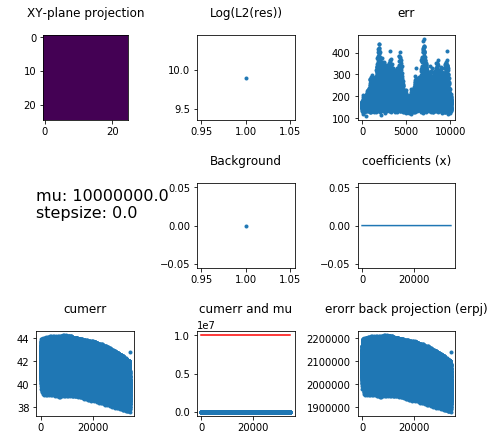

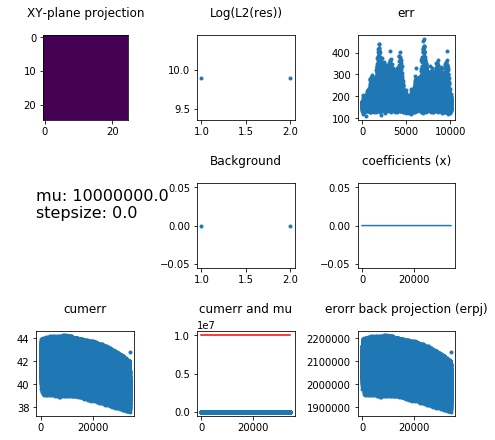

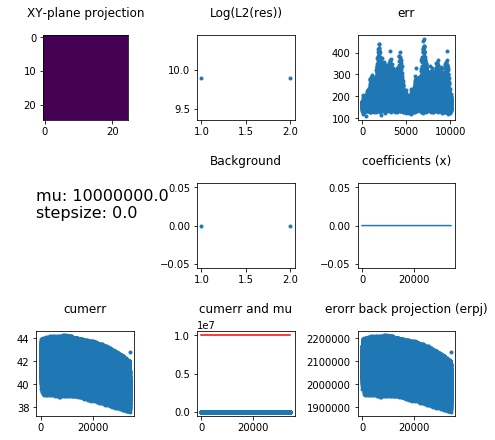

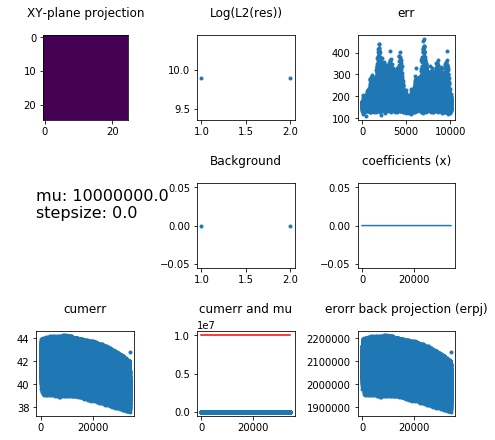

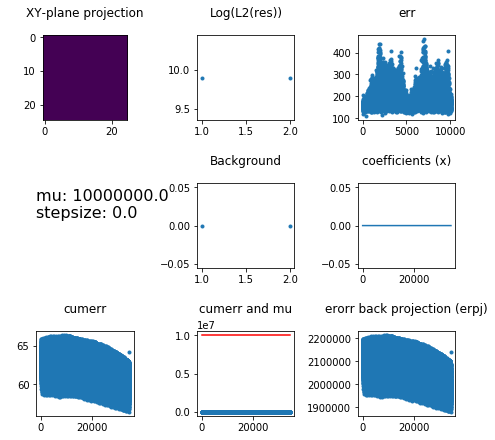

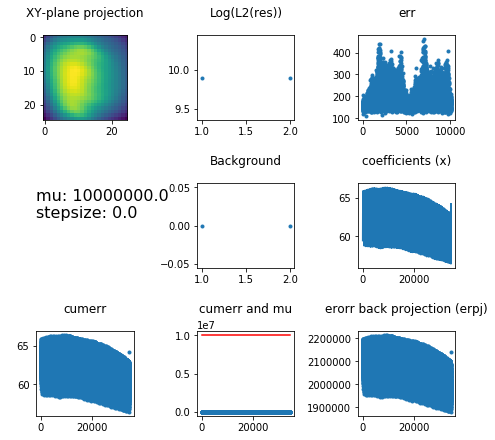

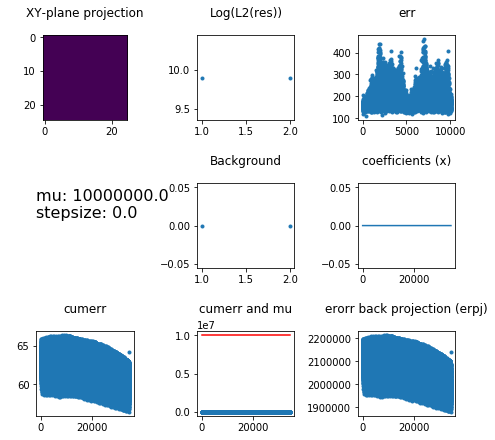

In [ ]:
# recover
    # input sensint matrix, and observation; 
    # yield: recovered vector
    # use scikit learn lasso solver
import time
A[:,len(candidate_locs)] = 550
Anorm = A/500
a = LinBreg(Anorm,np.zeros(A.shape[1]),blur.ravel())
a.debug = True
a.mu = 1e7
a.stepsize = 1e-5
a.alpha = 1
a.maxit = 2 # maximum iteration steps.
a.debug_it_int = 1
a.it_check_rem = 0       
a.getready()
a.go()